## Code Description:

This code will use the downloaded Fermi LAT lightcurves from the LC repository.



In [1]:
import os,sys
import numpy as np
import pandas as pd
import pyLCR
from astropy.io import fits
import pickle
import datetime
from codes_from_pylcr import *

import joblib
import glob
import matplotlib.pyplot as plt

# For training:
import xgboost as xgb




The Fermi-LAT Light Curve Repository Toolkit v0.1.0
Support Contact: Daniel Kocevski (daniel.kocevski@nasa.gov)


In [2]:
os.chdir('/Users/aadesai1/Desktop/In_use/ML_work/Fermi_amego_alert_project/Fermi_Sample/')

### Note that this code uses the Fermi LC saved as a pickle file in the following format:
  [array1],[array2],[array3],[array4]
-  array1 = [timebins_detections,flux] --------------> xvals = timebins_detections
-  array2 = [x_errors,np.transpose(flux_error)]------> xvals = timebins_detections
-  array3 = [timebins_upperlimits,flux_upper_limit]--> xvals = timebins_upperlimits
-  array4 = [timebins,ts] ----------------------------> xvals = timebins

In [3]:
saved_fermi_lcs = glob.glob(f'lc_downloaded_data/*.pickle')[:20]

In [4]:
for indi_i_val in range(len(saved_fermi_lcs)):
    with open(saved_fermi_lcs[indi_i_val], 'rb') as handle:
        loaded_fermi_lc = pickle.load(handle)

    
    all_times=loaded_fermi_lc[0][0]
    all_flux_with_ul=loaded_fermi_lc[0][1]
    print(indi_i_val,len(all_times),np.amin(all_times), "\n")

0 308 54686.5 

1 82 55050.49998842592 

2 104 54756.5 

3 77 54819.5 

4 405 54686.5 

5 136 54707.5 

6 216 54686.5 

7 150 54693.5 

8 206 54728.5 

9 388 54686.5 

10 206 54693.5 

11 118 54686.5 

12 161 54714.5 

13 313 54686.5 

14 134 54742.5 

15 84 54840.49998842592 

16 362 54686.5 

17 216 54707.5 

18 228 54686.5 

19 159 54735.5 



In [5]:
# Make new feature files or sue old ones:
make_feature_files=True

# Set Debug Flag
debug_this=False

In [6]:
for indi_i_val in range(len(saved_fermi_lcs)):
    if make_feature_files==False:
        continue
    with open(saved_fermi_lcs[indi_i_val], 'rb') as handle:
        loaded_fermi_lc = pickle.load(handle)

    all_times=loaded_fermi_lc[0][0]
    all_flux_with_ul=loaded_fermi_lc[0][1]
    if debug_this==True:
        all_times=loaded_fermi_lc[3][0]
        all_flux_with_ul=[]
        for time in all_times:
            found_flux=0
            for index_t_det in range(len(loaded_fermi_lc[0][0])):
                if time==loaded_fermi_lc[0][0][index_t_det]:
                    all_flux_with_ul.append(loaded_fermi_lc[0][1][index_t_det])
                    found_flux=1
            if found_flux==0:
                all_flux_with_ul.append(0)
        print(np.amax(np.asarray(all_flux_with_ul)*1e7),np.amin(np.asarray(all_flux_with_ul)*1e7))  
        plt.plot(all_times,np.asarray(all_flux_with_ul)*1e7)     
    
    df = pd.DataFrame.from_records(np.transpose([all_times,np.asarray(all_flux_with_ul)*1e7]), columns=['#MJD','flux'])
    df.set_index('#MJD', inplace=True) #This replaces the index with the MJD value

    if debug_this==True:
        # Display the DataFrame
        df.plot(figsize=(10,5))
    
    batch_df = pd.DataFrame()

    # Lagging features
    batch_df['lag_1'] = df['flux'].shift(1) # Prediction 0 Use numdays: 1 day 0-1 = 1
    batch_df['lag_4'] = df['flux'].shift(4) # Prediction 3 Use numdays: 7 day 3-7 = 4
    batch_df['lag_5'] = df['flux'].shift(5) # Prediction 2 Use numdays: -7 day 2-7 = 5
    batch_df['lag_6'] = df['flux'].shift(6) # Prediction 1 Use numdays: -7 day 1-7 = 6

    batch_df['lag_11'] = df['flux'].shift(11) # Prediction 3 Use numdays: -14 day 3-14 = 11
    batch_df['lag_12'] = df['flux'].shift(12) # Prediction 2 Use numdays: -14 day 2-14 = 12
    batch_df['lag_13'] = df['flux'].shift(13) # Prediction 1 Use numdays: -14 day 1-14 = 13


    # Rolling statistics
    batch_df['rolling_mean_7'] = df['flux'].rolling(window=7).mean().round(2)
    batch_df['rolling_std_7'] = df['flux'].rolling(window=7).std().round(2)

    # Inspect target variable - it's actually 3!

    # Lagging target variable
    batch_df['target_1d'] = df['flux'].shift(-1) # Next day
    batch_df['target_2d'] = df['flux'].shift(-2) # Second-next day
    batch_df['target_3d'] = df['flux'].shift(-3) # Third-next day

    # Run predictions with all three models

    predictions_ls = [] # list to store predictions
    batch_df = batch_df.dropna()

    corr = batch_df.corr()
    corr.style.background_gradient(cmap='coolwarm')
    features_df = batch_df[["lag_1", "lag_4", "lag_5", "lag_6", "lag_11", "lag_12", "lag_13", "rolling_mean_7", "rolling_std_7"]] 
    # Directory for feature store
    directory = "feature_store"
    if not os.path.exists(directory):
        os.makedirs(directory)


    id = "v1"
    features_df.to_csv(f'{directory}/{saved_fermi_lcs[indi_i_val][-24:-7]}_features_{id}.csv')
    #targets_df = batch_df[["target_1d", "target_2d", "target_3d", "target_9d"]] 
    targets_df = batch_df[["target_1d", "target_2d", "target_3d"]] 
    targets_df.to_csv(f'{directory}/{saved_fermi_lcs[indi_i_val][-24:-7]}_targets_{id}.csv')
    del loaded_fermi_lc,targets_df,batch_df,corr

In [7]:
# Use the marker to seperate of the data for learning and prediction:
#leave_number_indices = -40

# Make new feature files or sue old ones:
make_training_files=True

In [8]:
def train_model(fermi_lc_file,directory,id):

    
    X_train = pd.read_csv(f'{directory}/{fermi_lc_file}_features_{id}.csv')
    X_train.set_index('#MJD', inplace=True) #This replaces the index with the MJD value
    if len(X_train)/3>=40:
        leave_number_indices = -40
    else:
        leave_number_indices = -1*int(len(X_train)/3)
    print(len(X_train))
    X_train_mod = X_train.head(leave_number_indices) # save some rows for later
    X_train_mod

    targets_df = pd.read_csv(f'{directory}/{fermi_lc_file}_targets_{id}.csv')
    targets_df.set_index('#MJD', inplace=True) #This replaces the index with the MJD value
    targets_df_mod = targets_df.head(leave_number_indices) # save some rows for later 
    targets_df_mod

    # turn into a list
    y_train_ls= []
    for target in targets_df_mod.columns:
      y_train_ls.append(targets_df_mod[target])

    # Loop through targets - train one model for each target variable
    cv_results_ls = []
    for y_train in y_train_ls:

      # Prepare the DMatrix which is required by XGBoost
      dtrain = xgb.DMatrix(data=X_train_mod, label=y_train)

      # Define XGBoost parameters
      params = {
        #'max_depth': 6,
        #'min_child_weight': 1,
        'eta': 0.01,
        #'subsample': 1,
        #'colsample_bytree': 1,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse'
      }

      # Perform cross-validation
      cv_results = xgb.cv(
          params=params,
          dtrain=dtrain,
          num_boost_round=100,
          early_stopping_rounds=5,
          metrics='rmse',
          as_pandas=True,
          seed=123
      )
      cv_results_ls.append(cv_results)
      # Show the last mean RMSE as a measure of final performance
      print(f"Last mean RMSE: {cv_results['test-rmse-mean'][-1:]}")

    if debug_this==True:
      plt.figure(figsize=(10, 6))

      for idx, cv_results in enumerate(cv_results_ls):
          plt.plot(cv_results['test-rmse-mean'], label=f'CV Run {idx+1}')

      plt.title('Test RMSE Through Iterations')
      plt.xlabel('Number of Boosting Rounds')
      plt.ylabel('Mean RMSE')
      plt.legend()
      plt.show()

    # List to store the final models
    final_models_ls = []

    # Use the same params here you used in cross-validation
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse'
      }

    # Iterate through each set of cross-validation results and corresponding training targets
    for cv_results, y_train in zip(cv_results_ls, y_train_ls):
        # Determine the optimal number of boosting rounds from cross-validation results
        optimal_boost_rounds = cv_results['test-rmse-mean'].idxmin() + 1

        # Initialize the XGBoost regressor with determined parameters
        final_model = xgb.XGBRegressor(
            n_estimators=optimal_boost_rounds,
            **params
        )

        # Train the model on the full training dataset
        final_model.fit(X_train_mod, y_train)

        # Append the trained model to the list
        final_models_ls.append(final_model)


    if os.path.isdir('models')!=True:
        os.mkdir('models')
    #os.mkdir('models')
    # Save each model with a unique filename
    for idx, final_model in enumerate(final_models_ls):
        filename = f'models/{fermi_lc_file}_batch_demand_forecaster_model_{idx+1}.pkl'  # Create a unique filename for each model
        joblib.dump(final_model, filename)
    del dtrain,cv_results
    print("Ran!")
    return

In [9]:

for indi_i_val in range(len(saved_fermi_lcs)):
    if make_training_files==False:
        continue
    id = "v1"
    a = train_model(saved_fermi_lcs[indi_i_val][-24:-7],directory,id)


292
Last mean RMSE: 0    0.426848
Name: test-rmse-mean, dtype: float64
Last mean RMSE: 0    0.425569
Name: test-rmse-mean, dtype: float64
Last mean RMSE: 0    0.427518
Name: test-rmse-mean, dtype: float64
Ran!
66
Last mean RMSE: 0    0.284059
Name: test-rmse-mean, dtype: float64
Last mean RMSE: 39    0.260099
Name: test-rmse-mean, dtype: float64
Last mean RMSE: 24    0.262929
Name: test-rmse-mean, dtype: float64
Ran!
88
Last mean RMSE: 6    0.444411
Name: test-rmse-mean, dtype: float64
Last mean RMSE: 1    0.440206
Name: test-rmse-mean, dtype: float64
Last mean RMSE: 0    0.449001
Name: test-rmse-mean, dtype: float64
Ran!
61
Last mean RMSE: 9    0.364509
Name: test-rmse-mean, dtype: float64
Last mean RMSE: 1    0.369583
Name: test-rmse-mean, dtype: float64
Last mean RMSE: 7    0.377478
Name: test-rmse-mean, dtype: float64
Ran!
389
Last mean RMSE: 30    0.900643
Name: test-rmse-mean, dtype: float64
Last mean RMSE: 2    0.910795
Name: test-rmse-mean, dtype: float64
Last mean RMSE: 4    0

# Now we Predict!

In [10]:
# Run predictions with all three models

for indi_i_val in range(len(saved_fermi_lcs)):
    predictions_ls = [] # list to store predictions
    #if indi_i_val!=0:
    #    continue

    
    for idx in range(1, 4):  # Assuming there are 3 models
        filename = f'models/{saved_fermi_lcs[indi_i_val][-24:-7]}_batch_demand_forecaster_model_{idx}.pkl'  # Create a unique filename for each model
        model = joblib.load(filename)
        prediction = model.predict(features_df)
        predictions_ls.append(prediction)
    # Let's compare to the true values!

    targets_df = pd.read_csv(f'{directory}/{saved_fermi_lcs[indi_i_val][-24:-7]}_targets_{id}.csv')
    targets_df.set_index('#MJD', inplace=True) #This replaces the index with the MJD value

    predictions_df = pd.DataFrame({f'predicted_{i+1}d': predictions_ls[i] for i in range(len(predictions_ls))})
    predictions_df.index = features_df.index
    result_df = predictions_df.join(targets_df, how = "inner")
    #print(result_df)
    

In [11]:
import matplotlib as mpl

font = {'size'   : 25}
mpl.rc('font', **font) 

In [12]:
def make_plot(saved_fermi_lcs_arr,directory,id_val,target_val,predicted_val,example_source="none"):
    for indi_i_val in range(len(saved_fermi_lcs_arr)):
        predictions_ls = [] # list to store predictions
        if example_source!="none":
            if example_source!=saved_fermi_lcs[indi_i_val][-24:][:-7]:
                continue

        features_df = pd.read_csv(f'{directory}/{saved_fermi_lcs_arr[indi_i_val][-24:-7]}_features_{id_val}.csv')
        features_df.set_index('#MJD', inplace=True) #This replaces the index with the MJD value
        if len(features_df)/3>=40:
            leave_number_indices = -40
        else:
            leave_number_indices = -1*int(len(features_df)/3)
        
        for idx in range(1, 4):  # Assuming there are 3 models
            filename = f'models/{saved_fermi_lcs_arr[indi_i_val][-24:-7]}_batch_demand_forecaster_model_{idx}.pkl'  # Create a unique filename for each model
            model = joblib.load(filename)
            prediction = model.predict(features_df)
            predictions_ls.append(prediction)
        # Let's compare to the true values!

        targets_df = pd.read_csv(f'{directory}/{saved_fermi_lcs_arr[indi_i_val][-24:-7]}_targets_{id_val}.csv')
        targets_df.set_index('#MJD', inplace=True) #This replaces the index with the MJD value

        predictions_df = pd.DataFrame({f'predicted_{i+1}d': predictions_ls[i] for i in range(len(predictions_ls))})
        predictions_df.index = features_df.index
        result_df = predictions_df.join(targets_df, how = "inner")
        #print(result_df)
    
        fig = plt.figure(figsize=(12,7),dpi=200)
        ax = plt.subplot()

        ax.plot(result_df.index.array,result_df[target_val].array,"-",color="grey",linewidth=3,label="Original Data")
        ax.plot(result_df.index.array,result_df[predicted_val].array,":",color="red",linewidth=2,label="Training+Predicted Data")
        ax.plot([result_df.index.array[leave_number_indices],result_df.index.array[leave_number_indices]],[-0.05,10.15],"--",color="blue")  #For example agnstorm

        plt.ticklabel_format(axis='both', style='plain', scilimits=(4,9))

    
        plt.text(result_df.index.array[int(-1*leave_number_indices/2)],9.5,"Training")  #For  example
        plt.text(result_df.index.array[leave_number_indices+3],9.5,"Prediction") #For  example

        plt.xlabel("Time (MJD)")
        plt.ylabel("Count rate")
    
        plt.ylim(-0.05,10.15) #For  example
        plt.xlim(result_df.index.array[0]-0.5,result_df.index.array[-1]+11) #For   example
        #ax.set_xticklabels([str(int(x)) for x in ax.get_xticks()])
        plt.legend()

        plt.savefig(f'predictions/{saved_fermi_lcs_arr[indi_i_val][-24:-7]}_{target_val}.pdf',bbox_inches="tight")

        if example_source=="none":
            plt.close()
    


In [13]:
# Making all points for 1 day targets:
make_plot(saved_fermi_lcs,directory,id,'target_1d','predicted_1d')


In [14]:
# Making all points for 2 day targets:
make_plot(saved_fermi_lcs,directory,id,'target_2d','predicted_2d')


In [16]:
# Making all points for 3 day targets:
make_plot(saved_fermi_lcs,directory,id,'target_3d','predicted_3d')


## Example
To check an example, we will use one of the sources for which there exists a good amount of data.

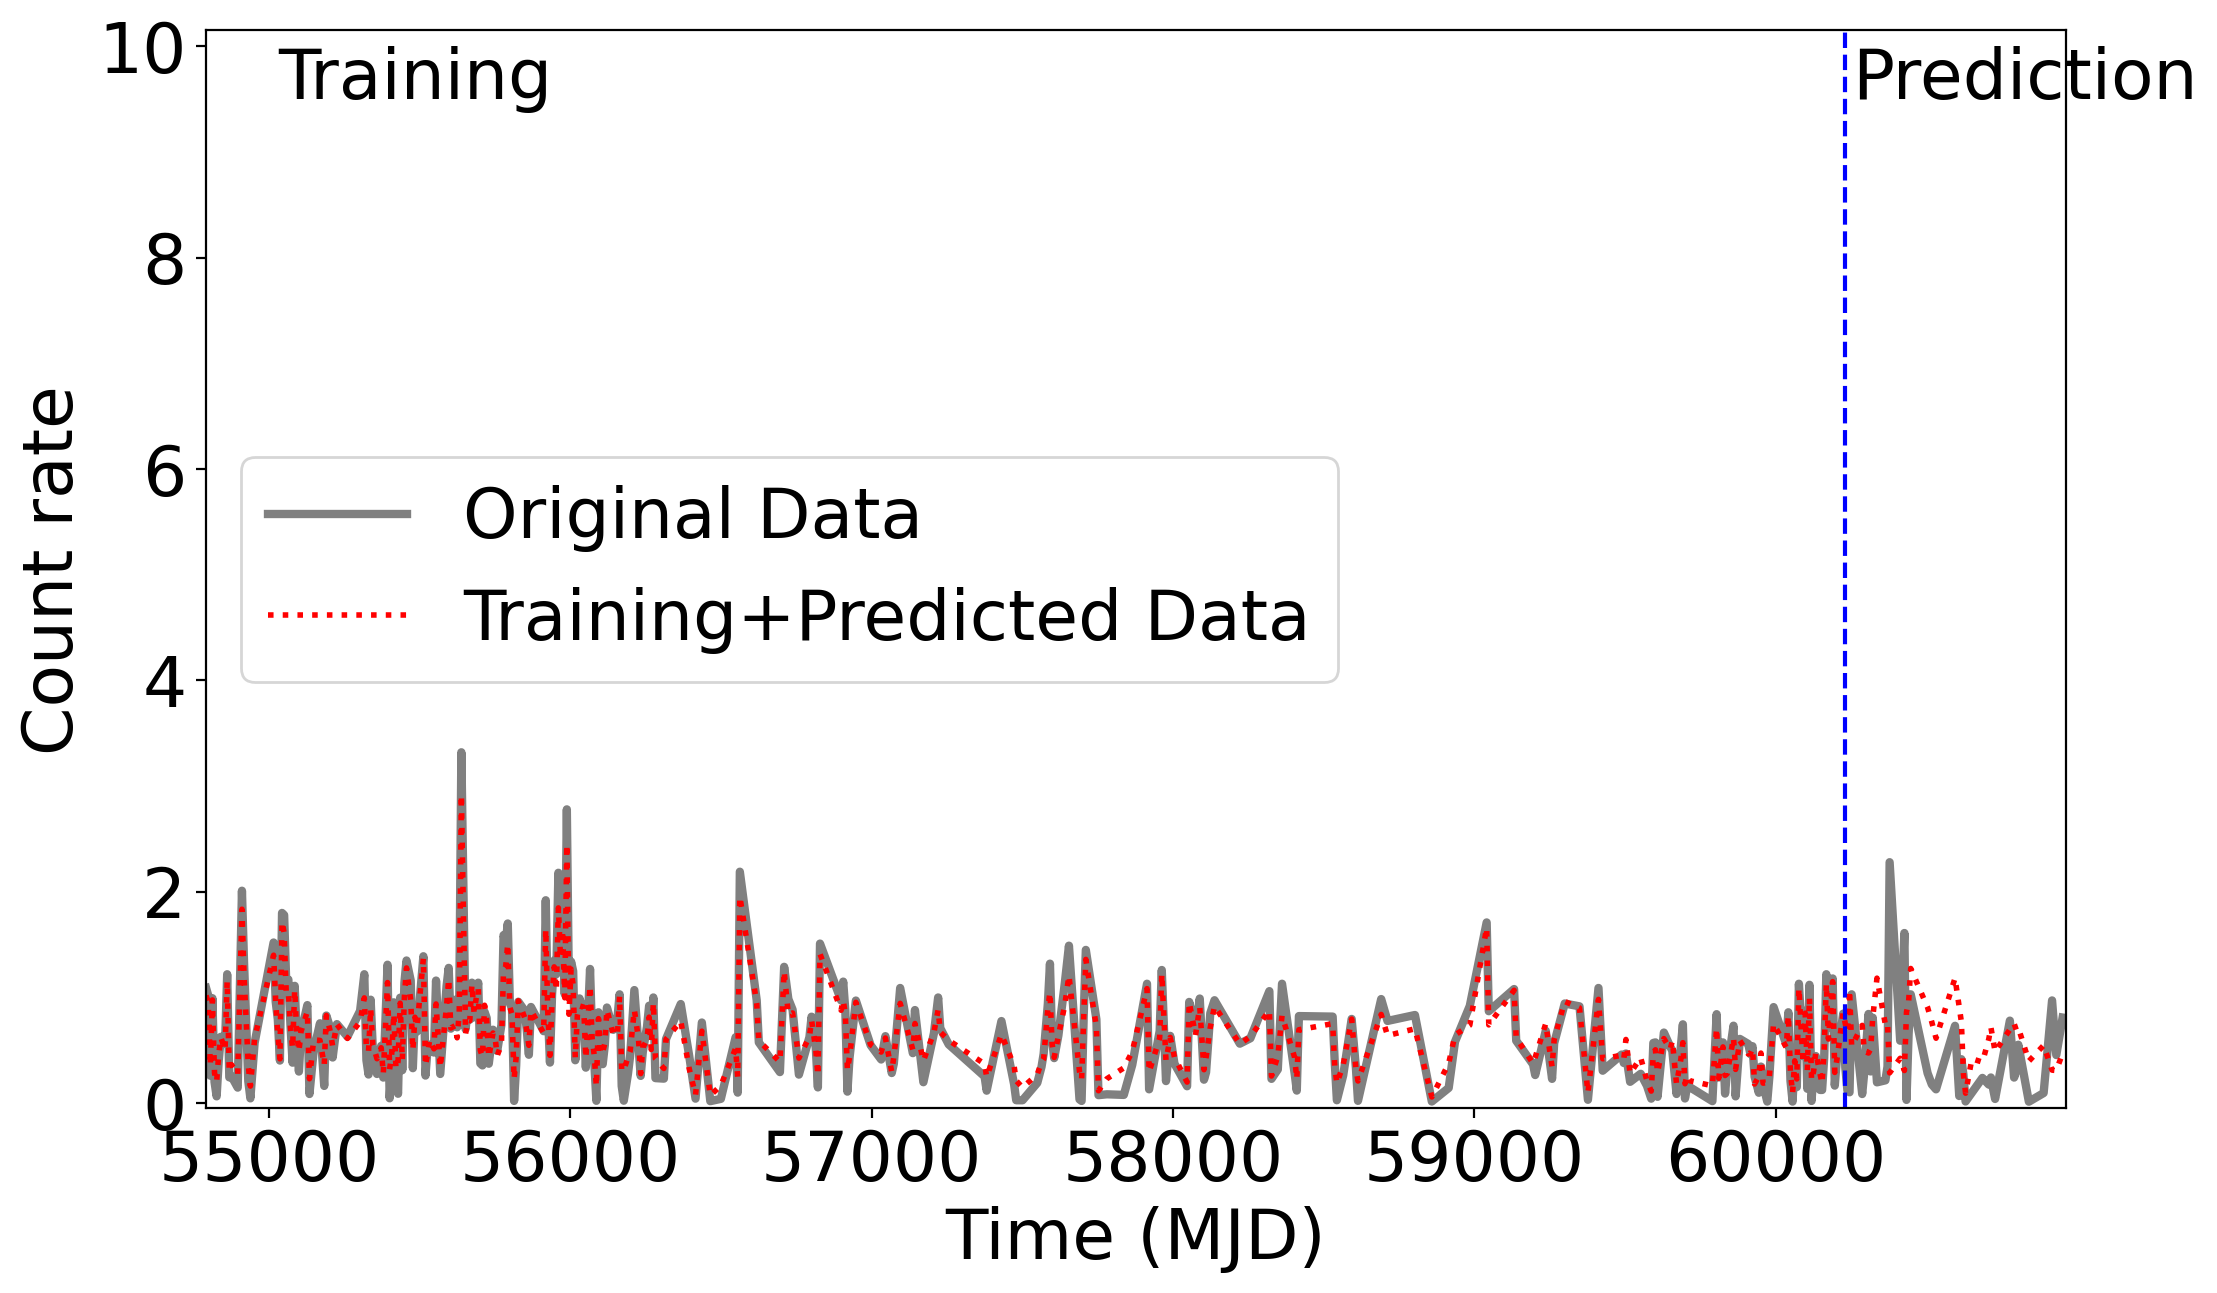

In [17]:
# Making an example plot using 3 day targets for one source:
make_plot(saved_fermi_lcs,directory,id,'target_3d','predicted_3d',example_source="4FGL_J1058.6-8003")

